In [12]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings(action='ignore')
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib
from matplotlib import font_manager, rc
import platform

if platform.system() == 'Windows':
# 윈도우인 경우
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
# Mac 인 경우
    rc('font', family='AppleGothic')
    
matplotlib.rcParams['axes.unicode_minus'] = False   

## 회귀분석 이후 데이터 불러오기

In [13]:
#데이터 불러오기
df = pd.read_csv('서울시_회귀분석후_최종.csv',encoding='utf-8')

#독립변수 추출
X_col = df.drop(['시군구','행정구역'],axis=1,inplace=False).columns.tolist()


# 스케일링 : RobustScaler -> 이상치 있을 때 효과적
scaler = RobustScaler()
df['쓰레기발생량'] = scaler.fit_transform(df[['쓰레기발생량']])

## 클러스터링

#### 함수 정의

In [14]:
# elbow plot
# SSE : 클러스터 내 오차제곱합 
def elbow(X):
    sse = []
    for i in range(1,11):
        km = KMeans(n_clusters = i, init='k-means++', random_state=random_state)
        km.fit(X)
        sse.append(km.inertia_)
        
    plt.plot(range(1,11), sse, marker='o')
    plt.xlabel('클러스터 개수')
    plt.ylabel('SSE')
    plt.show()
    
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features):     
    #from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
   
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
   
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
   
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
       
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=random_state)
        cluster_labels = clusterer.fit_predict(X_features)
       
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
       
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
       
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
           
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
           
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

# make_blobs 을 통해 clustering 을 위한 4개의 클러스터 중심의 500개 2차원 데이터 셋 생성  


#클러스터 개수 = n
def clustering(df,col,n):
    estimator = KMeans(n_clusters = n,random_state=random_state)
    # 라벨 생성
    ids = estimator.fit_predict(df[col])
    
    return ids
    

### 인구수 - 쓰레기발생량 

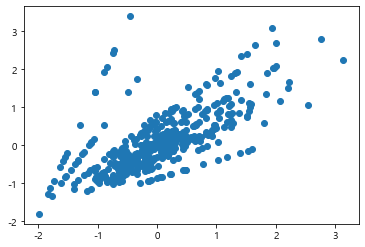

In [15]:
#인구수 - 쓰레기발생량 시각화
#x축 : 인구수
#y축 : 쓰레기발생량
plt.scatter('인구수','쓰레기발생량',data=df)

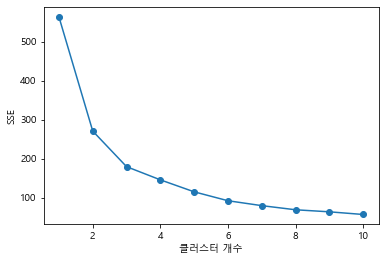

In [16]:
# elbow plot 그리기
# 클러스터 개수에 따른 SSE 시각화
# SSE : 각 클러스터 내 오차제곱합 -> 작을수록 잘 나뉘었다는 뜻
# 클러스터 개수가 너무 많아도 문제 
# 그래프의 기울기가 완만해지는 지점의 클러스터 개수 선택 -> 클러스터 개수가 늘어남에 따라 줄어드는 SSE 양이 적다.


random_state= 2345

df_0 = df.copy()[['시군구','행정구역','인구수','쓰레기발생량']]
X0_col = ['인구수','쓰레기발생량']
elbow(df[X0_col])

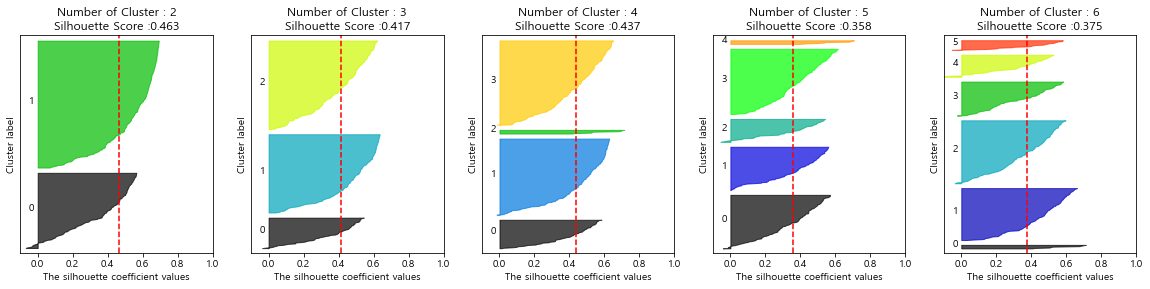

In [17]:
# 실루엣계수 : 각 개체와 클러스터 내의 다른 개체, 다른 클러스터 객체와의 거리를 계산하여 얻은 계수
# -1 ~ 1 값을 가지며 1에 가까울 수록 잘 분류되었음을 의미
# 0에 가까울수록 잘 분류되지 않았음을 의미
# 음수 값의 경우 개체가 다른 클러스터로 분류되었음을 의미

# 전체 평균 실루엣계수도 중요하지만 
# 개별 데이터 값의 실루엣계수도 중요 -> 편차가 작아야 함


# cluster 개수를 2개, 3개, 4개, 5개 일때의 클러스터별 실루엣 계수 평균값을 시각화 

visualize_silhouette([ 2, 3, 4, 5, 6], df_0[X0_col])

In [18]:
# elbow plot, 실루엣 계수를 바탕으로 클러스터 개수 지정 후 데이터프레임에 클러스터 라벨 추가
df_0['label'] = clustering(df,X0_col,4)

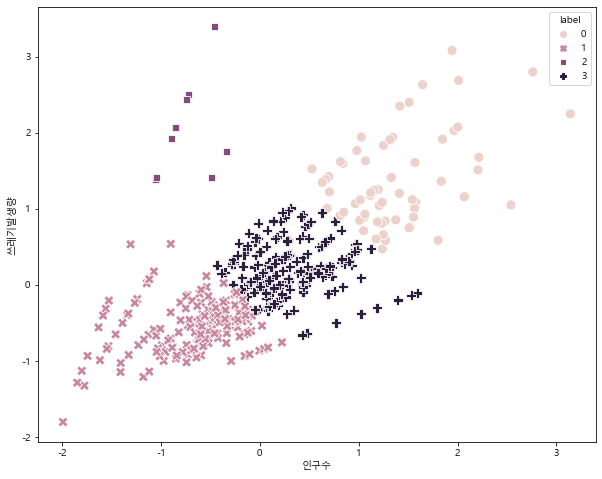

In [19]:
# 클러스터링 결과 시각화
plt.figure(figsize=(10,8))
sns.scatterplot(x='인구수', 
                y='쓰레기발생량', 
                
                hue='label', # different colors by group
                style='label', # different shapes by group
                s=100, # marker size
                data=df_0)
plt.show()



In [20]:
# 0,2번 클러스터가 적합하다고 판단 
# 0번 클러스터 : 인구수 많고, 쓰레기발생량 많음
# 2번 클러스터 : 인구수 대비 쓰레기발생량 많음

#0번 클러스터 동 리스트 생성
temp_dong0_1 = df_0.loc[df_0['label']==0]['행정구역'].values.tolist()

#2번 클러스터 동 리스트 생성
temp_dong0_2 = df_0.loc[df_0['label']==2]['행정구역'].values.tolist()

#0,2번 클러스터 동 리스트 결합 
dong0 = temp_dong0_1 + temp_dong0_2

### 주거용 - 분리수거함개수

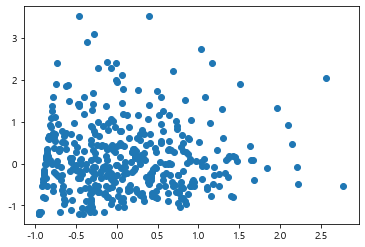

In [21]:
#주거용 - 분리수거함개수 시각화
#x축 : 주거용
#y축 : 분리수거함개수

plt.scatter('주거용','분리수거함개수',data=df)

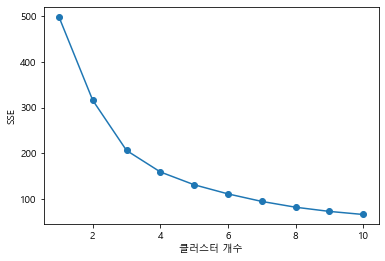

In [22]:
# elbow plot 그리기
# 클러스터 개수에 따른 SSE 시각화
# SSE : 각 클러스터 내 오차제곱합 -> 작을수록 잘 나뉘었다는 뜻
# 클러스터 개수가 너무 많아도 문제 
# 그래프의 기울기가 완만해지는 지점의 클러스터 개수 선택 -> 클러스터 개수가 늘어남에 따라 줄어드는 SSE 양이 적다.

df_1 = df.copy()[['시군구','행정구역','주거용','분리수거함개수']]
X1_col = ['주거용','분리수거함개수']
elbow(df[X1_col])

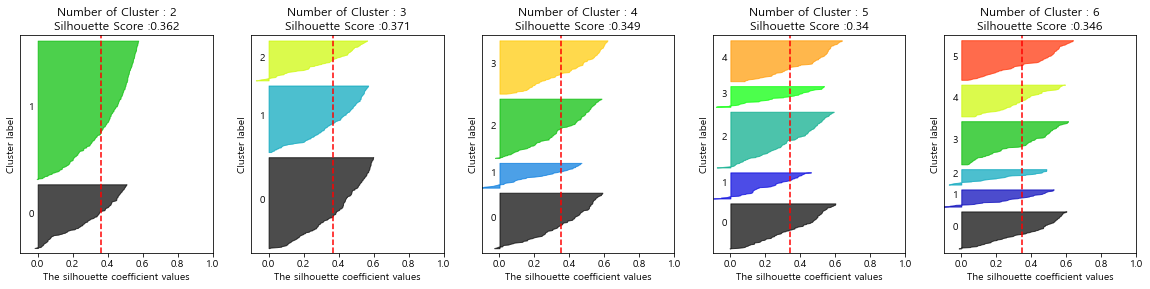

In [23]:
# 실루엣계수 : 각 개체와 클러스터 내의 다른 개체, 다른 클러스터 객체와의 거리를 계산하여 얻은 계수
# -1 ~ 1 값을 가지며 1에 가까울 수록 잘 분류되었음을 의미
# 0에 가까울수록 잘 분류되지 않았음을 의미
# 음수 값의 경우 개체가 다른 클러스터로 분류되었음을 의미

# 전체 평균 실루엣계수도 중요하지만 
# 개별 데이터 값의 실루엣계수도 중요 -> 편차가 작아야 함


# cluster 개수를 2개, 3개, 4개, 5개 일때의 클러스터별 실루엣 계수 평균값을 시각화 

visualize_silhouette([ 2, 3, 4, 5, 6], df_1[X1_col])

In [24]:
# elbow plot, 실루엣 계수를 바탕으로 클러스터 개수 지정 후 데이터프레임에 클러스터 라벨 추가
df_1['label'] = clustering(df,X1_col,4)

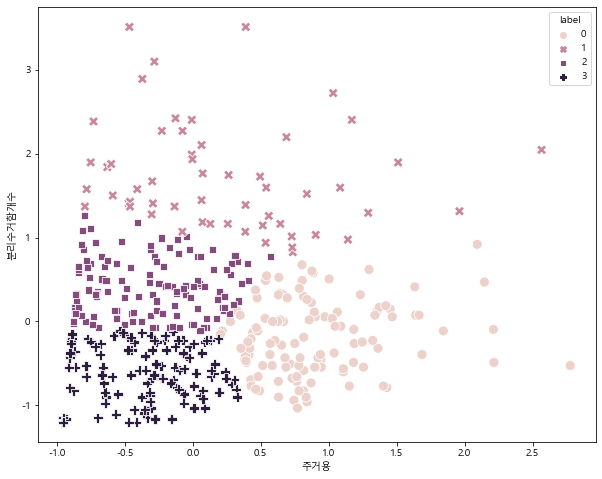

In [25]:
# 클러스터링 결과 시각화
plt.figure(figsize=(10,8))
sns.scatterplot(x='주거용', 
                y='분리수거함개수', 
                
                hue='label', # different colors by group
                style='label', # different shapes by group
                s=100, # marker size
                data=df_1)
plt.show()


In [26]:
# 0번 클러스터가 적합하다고 판단 
# 0번 클러스터 : 주거용 건물 많으나, 분리수거함 개수 적음


#0번 클러스터 동 리스트 생성
dong1 = df_1.loc[df_1['label']==0]['행정구역'].values.tolist()



### 인구수-일인가구수

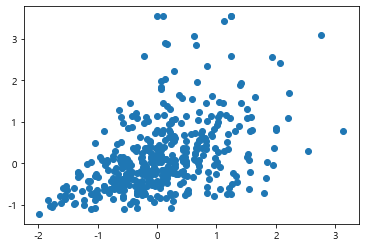

In [27]:
#인구수 - 일인가구수 시각화
#x축 : 인구수
#y축 : 일인가구수


plt.scatter('인구수','일인가구수',data=df)

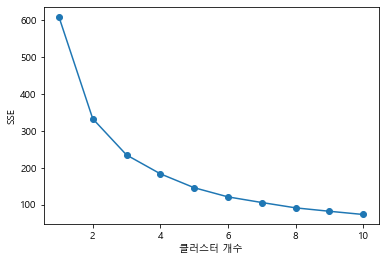

In [28]:
# elbow plot 그리기
# 클러스터 개수에 따른 SSE 시각화
# SSE : 각 클러스터 내 오차제곱합 -> 작을수록 잘 나뉘었다는 뜻
# 클러스터 개수가 너무 많아도 문제 
# 그래프의 기울기가 완만해지는 지점의 클러스터 개수 선택 -> 클러스터 개수가 늘어남에 따라 줄어드는 SSE 양이 적다.

df_2 = df.copy()[['시군구','행정구역','인구수','일인가구수']]
X2_col = ['인구수','일인가구수']
elbow(df[X2_col])

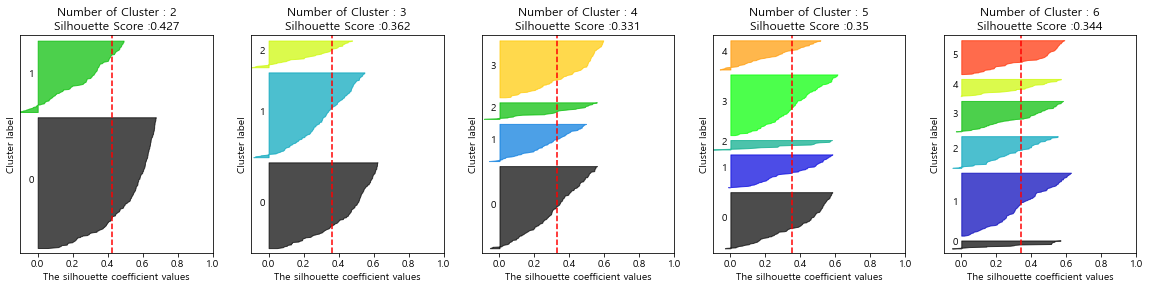

In [29]:
# 실루엣계수 : 각 개체와 클러스터 내의 다른 개체, 다른 클러스터 객체와의 거리를 계산하여 얻은 계수
# -1 ~ 1 값을 가지며 1에 가까울 수록 잘 분류되었음을 의미
# 0에 가까울수록 잘 분류되지 않았음을 의미
# 음수 값의 경우 개체가 다른 클러스터로 분류되었음을 의미

# 전체 평균 실루엣계수도 중요하지만 
# 개별 데이터 값의 실루엣계수도 중요 -> 편차가 작아야 함


# cluster 개수를 2개, 3개, 4개, 5개 일때의 클러스터별 실루엣 계수 평균값을 시각화 
visualize_silhouette([ 2, 3, 4, 5, 6], df_2[X2_col])

In [30]:
# elbow plot, 실루엣 계수를 바탕으로 클러스터 개수 지정 후 데이터프레임에 클러스터 라벨 추가
df_2['label'] = clustering(df,X2_col,4)

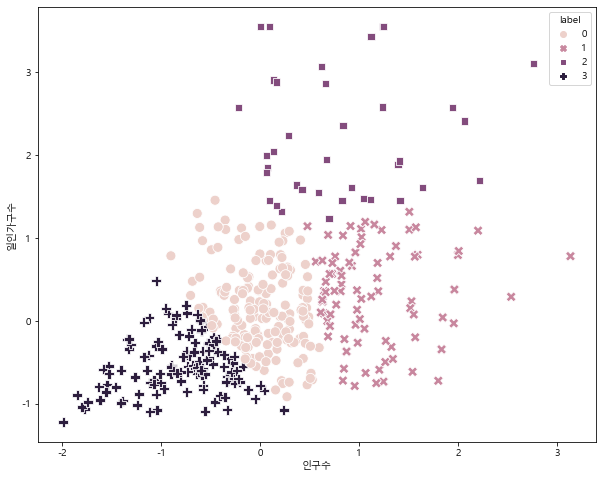

In [31]:
# 클러스터링 결과 시각화
plt.figure(figsize=(10,8))
sns.scatterplot(x='인구수', 
                y='일인가구수', 
                
                hue='label', # different colors by group
                style='label', # different shapes by group
                s=100, # marker size
                data=df_2)
plt.show()


In [32]:
# 2번 클러스터가 적합하다고 판단 
# 2번 클러스터 : 인구수 대비 일인가구수 많다 or 인구수 많고, 일인가구수 많다


#0번 클러스터 동 리스트 생성
dong2 = df_2.loc[df_2['label']==2]['행정구역'].values.tolist()


## 3개 클러스터 동 교집합 

In [33]:
# 인구수 - 쓰레기 발생량 target 클러스터 포함 동

for idx in range(len(dong0)):
    if idx ==len(dong0)-1:
        print(dong0[idx])
    else :
        print(dong0[idx],end=", ")
        


이촌1동, 광장동, 용신동, 전농1동, 답십리1동, 답십리2동, 장안1동, 장안2동, 면목본동, 묵1동, 신내1동, 길음1동, 종암동, 석관동, 창2동, 녹번동, 불광1동, 역촌동, 진관동, 연희동, 공덕동, 성산2동, 상암동, 목5동, 신정3동, 염창동, 등촌3동, 화곡1동, 화곡본동, 가양1동, 발산1동, 우장산동, 공항동, 방화1동, 신도림동, 오류2동, 독산1동, 시흥1동, 여의동, 당산2동, 문래동, 상도1동, 대방동, 청룡동, 은천동, 서초3동, 서초4동, 반포1동, 양재1동, 삼성2동, 대치2동, 역삼1동, 역삼2동, 도곡2동, 세곡동, 오금동, 잠실2동, 잠실3동, 강일동, 상일동, 암사1동, 천호2동, 길동, 평창동, 혜화동, 다산동, 약수동, 청구동, 신당5동, 동화동, 황학동, 중림동


In [34]:
# 주거용 - 분리수거함개수 target 클러스터 포함 동


for idx in range(len(dong1)):
    if idx ==len(dong1)-1:
        print(dong1[idx])
    else :
        print(dong1[idx],end=", ")
        


청운효자동, 혜화동, 후암동, 용산2가동, 청파동, 이태원2동, 보광동, 마장동, 금호2·3가동, 성수2가1동, 용답동, 화양동, 군자동, 중곡1동, 중곡2동, 중곡3동, 중곡4동, 자양1동, 자양2동, 자양4동, 구의1동, 구의2동, 용신동, 제기동, 전농1동, 이문1동, 이문2동, 면목2동, 면목4동, 면목본동, 면목7동, 면목3·8동, 중화2동, 묵2동, 망우본동, 망우3동, 성북동, 삼선동, 동선동, 안암동, 정릉2동, 정릉3동, 월곡2동, 장위1동, 장위2동, 석관동, 삼양동, 미아동, 송중동, 송천동, 번1동, 수유1동, 수유2동, 수유3동, 우이동, 창3동, 도봉1동, 쌍문1동, 방학1동, 방학2동, 상계5동, 녹번동, 불광2동, 갈현1동, 갈현2동, 대조동, 응암3동, 역촌동, 신사2동, 충현동, 신촌동, 남가좌2동, 북가좌2동, 공덕동, 서교동, 합정동, 망원1동, 연남동, 성산1동, 신월1동, 신월3동, 화곡4동, 화곡본동, 화곡8동, 공항동, 방화2동, 구로2동, 고척2동, 개봉1동, 독산2동, 독산3동, 독산4동, 시흥1동, 시흥4동, 시흥5동, 영등포본동, 도림동, 신길1동, 대림2동, 대림3동, 노량진2동, 상도3동, 상도4동, 흑석동, 사당1동, 보라매동, 행운동, 서원동, 신원동, 서림동, 관악구_신사동, 마천1동, 마천2동, 송파1동, 석촌동, 삼전동, 잠실본동, 암사1동, 천호1동, 천호2동, 천호3동, 성내2동


In [35]:
# 인구수 - 일인가구수 target 클러스터 포함 동


for idx in range(len(dong2)):
    if idx ==len(dong2)-1:
        print(dong2[idx])
    else :
        print(dong2[idx],end=", ")


화양동, 용신동, 전농1동, 면목본동, 공릉1동, 신촌동, 연희동, 공덕동, 서교동, 성산2동, 등촌1동, 화곡1동, 가양1동, 구로3동, 가산동, 독산1동, 영등포동, 당산2동, 상도1동, 사당1동, 행운동, 청룡동, 인헌동, 서원동, 서림동, 관악구_신사동, 신림동, 대학동, 논현1동, 역삼1동, 방이2동, 석촌동, 삼전동, 문정2동, 잠실본동, 천호2동, 길동


In [439]:
# # 각 동이 속하는 구 리스트 생성
# gu_list = []
# for dong in dong0:
#     temp_gu = df.loc[df['행정구역']==dong]['시군구'].values[0]
#     gu_list.append(temp_gu)

# # 구 개수 count 
# gu_df = pd.DataFrame(gu_list,columns=['시군구'])
# gu_df['count'] = 1
# gu_df.groupby(by='시군구').count().sort_values(by='count',ascending=False)

In [38]:
# 3개 클러스터 동 교집합

최종동_list = set(dong0) & set(dong1) & set(dong2)

print(최종동_list)

{'공덕동', '면목본동', '전농1동', '천호2동', '용신동'}


In [39]:
# 각 동이 속하는 구 리스트 생성
gu_list = []
for dong in 최종동_list:
    temp_gu = df.loc[df['행정구역']==dong]['시군구'].values[0]
    gu_list.append(temp_gu)
    
# 구 개수 count 
gu_df = pd.DataFrame(gu_list,columns=['시군구'])
gu_df['count'] = 1
gu_df.groupby(by='시군구').count().sort_values(by='count',ascending=False)

,count
시군구,
동대문구,2
강동구,1
마포구,1
중랑구,1
